# Score Generation
Score generation (per row) is a three stage process.

## 1 VEP
If a row has a `VEP` score over 0.65, then `ot_v2g_score` is a linear transform (that maps [0.65, 1] to [0.9, 1]) of the `VEP` score and the process moves to the next row.
If not, we move to stage two for this row.

## 2 Functional genomics
If a row has one or more of `dhs`, `fantom5`, `pchic` and `gtex` above zero (`gtex` above 0.999975), then `ot_v2g_score` is a linear transform (that maps [0, 1] to [0.5, 0.9]) of the formula below and the process moves to the next row.

$$
\frac{13GTEx + 3Fantom5 + 1.5DHS + 1.5PCHiC}{19}
$$

If not, we move to stage three for this row.

## 3 Nearest gene
If a row has `nearest` above zero, then `ot_v2g_score` is 0.5.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
pg = pd.read_csv('postgap.20171113.filtered.txt.gz', sep='\t', na_values=['None'])
print(pg.shape)
pg.head()

/Users/gpeat/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(31224438, 38)


,ld_snp_rsID,chrom,pos,afr_maf,amr_maf,eas_maf,eur_maf,sas_maf,gene_symbol,gene_id,...,vep_sum,vep_mean,GTEx,VEP,Fantom5,DHS,PCHiC,Nearest,Regulome,VEP_reg
0,rs10740053,10,63702584,0.7784,0.5317,0.6736,0.6928,0.4888,CISD1,ENSG00000122873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
1,rs10740054,10,63702586,0.7784,0.5317,0.6736,0.6928,0.4877,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
2,rs10740053,10,63702584,0.7784,0.5317,0.6736,0.6928,0.4888,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
3,rs4506592,10,63727187,0.7020,0.5101,0.6538,0.6511,0.4785,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.008807,0.0,0.0,0
4,rs11332367,10,63736618,0.8396,0.5303,0.6448,0.6700,0.4826,RTKN2,ENSG00000182010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007876,0.0,0.0,0


In [3]:
vep = pd.read_csv('eco_scores.tsv', sep='\t', na_values=['None'])
vep = vep.rename(columns={
    '-http://identifiers.org/eco/cttv_mapping_pipeline': 'url',
    'cttv_mapping_pipeline': 'vep_term',
    '1.': 'vep_value'
})
print(vep.shape)
vep.head()

(42, 3)


,url,vep_term,vep_value
0,http://purl.obolibrary.org/obo/ECO_0000205,curator_inference,1.00
1,http://purl.obolibrary.org/obo/SO_0002165,trinucleotide_repeat_expansion,1.00
2,http://purl.obolibrary.org/obo/SO_0001060,sequence_variant,0.50
3,http://purl.obolibrary.org/obo/SO_0001566,regulatory_region_variant,0.60
4,http://purl.obolibrary.org/obo/SO_0001567,stop_retained_variant,0.65


In [4]:
vep_term2value = {r.vep_term: r.vep_value for (i, r) in vep.iterrows()}

In [ ]:
def ot_v2g_score(r):
    '''
    Calculate the variant-to-gene score for a row.
    
    Arguments:
    r   -- A row from a pandas DataFrame of the POSTGAP data.
    
    Returns:
    v2g -- The variant-to-gene score.
    '''
    GTEX_CUTOFF = 0.999975
    
    # stage 1
    if not pd.isnull(r.vep_terms):
        vep_terms = r.vep_terms.split(',')
        vep_score = max([vep_term2value[t] for t in vep_terms])
        if vep_score >= 0.65:
            return ((vep_score - 0.65) / 0.35) * 0.1 + 0.9
    
    # stage 2
    if (r.GTEx > GTEX_CUTOFF) or (r.PCHiC > 0) or (r.DHS > 0) or (r.Fantom5 > 0):
        gtex = 1 if (r.GTEx > GTEX_CUTOFF) else 0
        pchic = 1 if (r.PCHiC > 0) else 0
        dhs = 1 if (r.DHS > 0) else 0
        fantom5 = 1 if (r.Fantom5 > 0) else 0
        vep_score = ((gtex * 13) + (fantom5 * 3) + (dhs * 1.5) + (pchic * 1.5)) / 19
        return vep_score * 0.4 + 0.5
    
    # stage 3
    if (r.Nearest > 0):
        return 0.5

In [24]:
def ot_v2g_score(r, vep_map):
    '''
    Calculate the variant-to-gene score for a row.
    
    Arguments:
    r       -- A row from a pandas DataFrame of the POSTGAP data.
    vep_map -- A dict of numeric values associated with VEP terms
    
    Returns:
    v2g     -- The variant-to-gene score.
    '''
    GTEX_CUTOFF = 0.999975
    
    # stage 1
    if not pd.isnull(r.vep_terms):
        vep_terms = r.vep_terms.split(',')
        vep_score = max([
            0 if t == 'start_retained_variant' else vep_map[t] # start_retained_variant needs adding to map
            for t in vep_terms
        ])
        if vep_score >= 0.65:
            return ((vep_score - 0.65) / 0.35) * 0.1 + 0.9
    
    # stage 2
    if (r.GTEx > GTEX_CUTOFF) or (r.PCHiC > 0) or (r.DHS > 0) or (r.Fantom5 > 0):
        gtex = 1 if (r.GTEx > GTEX_CUTOFF) else 0
        pchic = 1 if (r.PCHiC > 0) else 0
        dhs = 1 if (r.DHS > 0) else 0
        fantom5 = 1 if (r.Fantom5 > 0) else 0
        vep_score = ((gtex * 13) + (fantom5 * 3) + (dhs * 1.5) + (pchic * 1.5)) / 19
        return vep_score * 0.4 + 0.5
    
    # stage 3
    if (r.Nearest > 0):
        return 0.5

In [6]:
def hist(values, title='', xlabel='Value', bins=200):
    plt.figure(figsize=(15, 5))
    plt.hist(values, bins=bins, log=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

In [17]:
pg_geo_filtered = pg[(pg.gene_chrom.astype(str) == pg.chrom.astype(str)) & (np.absolute(pg.pos - pg.gene_tss) < 1000000)]

In [20]:
pg_less_gtex = pg_geo_filtered[
    (
        (pg_geo_filtered.GTEx > 0.999975) |
        (pg_geo_filtered.Fantom5 > 0) |
        (pg_geo_filtered.DHS > 0) |
        (pg_geo_filtered.PCHiC > 0) |
        (pg_geo_filtered.Nearest > 0) |
        (~pg_geo_filtered.vep_terms.isnull())
    )
]

In [16]:
len(pg)

31224438

In [21]:
len(pg_geo_filtered)

30519969

In [22]:
len(pg_less_gtex)

5655967

In [25]:
pg_with_v2g = pg_less_gtex.copy()
# pg_with_v2g = pg.head(1000000).copy()
pg_with_v2g['ot_v2g_score'] = pg_with_v2g.apply(ot_v2g_score, args=(vep_term2value,), axis=1)
pg_with_v2g.head()

,ld_snp_rsID,chrom,pos,afr_maf,amr_maf,eas_maf,eur_maf,sas_maf,gene_symbol,gene_id,...,vep_mean,GTEx,VEP,Fantom5,DHS,PCHiC,Nearest,Regulome,VEP_reg,ot_v2g_score
4,rs11332367,10,63736618,0.8396,0.5303,0.6448,0.6700,0.4826,RTKN2,ENSG00000182010,...,0.0,0.0,0.0,0.0,0.0,0.007876,0.0,0.0,0,0.531579
9,rs11403206,10,63703230,0.6800,0.4971,0.6468,0.6431,0.3773,RTKN2,ENSG00000182010,...,0.0,0.0,0.0,0.0,0.0,0.008265,0.0,0.0,0,0.531579
21,rs12828252,12,96612094,0.4531,0.4928,0.6032,0.3101,0.3129,CCDC38,ENSG00000165972,...,0.0,0.0,0.0,0.0,0.0,0.011022,0.0,0.0,0,0.531579
23,rs3831818,12,96616149,0.3366,0.3703,0.5992,0.2724,0.2914,CDK17,ENSG00000059758,...,0.0,0.0,0.0,0.0,0.0,0.030662,0.0,0.0,0,0.531579
25,rs2268507,12,96614125,0.4312,0.4798,0.5992,0.3042,0.3098,CCDC38,ENSG00000165972,...,0.0,0.0,0.0,0.0,0.0,0.011022,0.0,0.0,0,0.531579


**Question**: What proportion of the data now has a variant-to-gene score?

In [33]:
print('Rows with no v2g score: {}%'.format(pg_with_v2g['ot_v2g_score'].isnull().sum() * 100 / len(pg_with_v2g)))

Rows with no v2g score: 2.4676416959292724%


**Question**: How is the variant-to-gene score distributed?

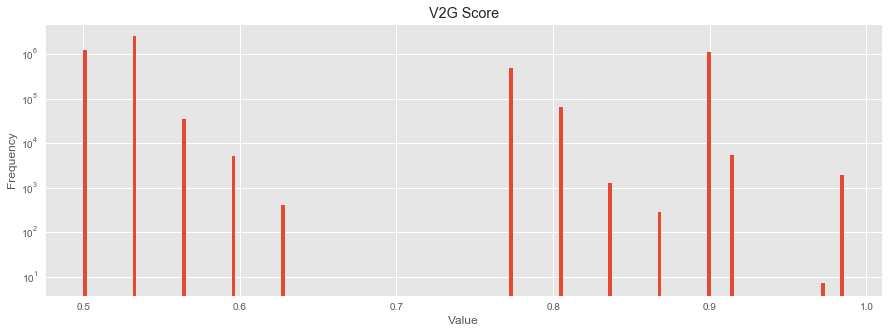

In [27]:
hist(pg_with_v2g.ot_v2g_score.dropna(), 'V2G Score')

**Question**: How many (gene, snp) pairs share their snp with a (gene, snp) pair with `vep_score` over 0.65?

In [28]:
def vep_score(r, vep_map):
    if not pd.isnull(r.vep_terms):
        vep_terms = r.vep_terms.split(',')
        vep_score = max([
            0 if t == 'start_retained_variant' else vep_map[t]
            for t in vep_terms
        ])
        return vep_score

In [67]:
gene_snps = pg_less_gtex.groupby(['gene_id', 'ld_snp_rsID']).first()
vep_scores = gene_snps.apply(vep_score, args=(vep_term2value,), axis=1)
hits = vep_scores[(vep_scores >= 0.65)].reset_index(['gene_id', 'ld_snp_rsID']).rename(columns={
    'gene_id': 'hit_gene_id',
    0: 'hit_vep_score'
})
not_hits = vep_scores[(vep_scores < 0.65)].reset_index(['gene_id', 'ld_snp_rsID']).rename(columns={
    'gene_id': 'not_hit_gene_id',
    0: 'not_hit_vep_score'
})
not_hits_linked_to_hits = pd.merge(hits, not_hits, on=('ld_snp_rsID',))
not_hits_linked_to_hits.groupby(['hit_gene_id', 'ld_snp_rsID']).head()

,hit_gene_id,ld_snp_rsID,hit_vep_score,not_hit_gene_id,not_hit_vep_score
0,ENSG00000000419,rs73909848,0.65,ENSG00000124217,0.6
1,ENSG00000000460,rs1131498,0.65,ENSG00000188404,0.6
2,ENSG00000000460,rs12938,0.65,ENSG00000188404,0.6
3,ENSG00000000460,rs4987280,0.65,ENSG00000188404,0.6
4,ENSG00000002330,rs144682603,0.65,ENSG00000173264,0.6
5,ENSG00000002330,rs34292685,0.65,ENSG00000173264,0.6
6,ENSG00000002330,rs477895,0.65,ENSG00000173264,0.6
7,ENSG00000002822,rs10950399,0.65,ENSG00000176349,0.6
8,ENSG00000002822,rs10950400,0.65,ENSG00000176349,0.6
9,ENSG00000002822,rs11764124,0.65,ENSG00000176349,0.6
